Francis Deck

    The MIT License (MIT) Copyright (c) 2018-2021 Francis Deck

    Permission is hereby granted, free of charge, to any person obtaining a copy of this 
    software and associated documentation files (the "Software"), to deal in the Software 
    without restriction, including without limitation the rights to use, copy, modify, 
    merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
    to permit persons to whom the Software is furnished to do so, subject to the 
    following conditions:

    The above copyright notice and this permission notice shall be included in all 
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
    INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
    PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
    HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
    OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
    SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [25]:
# Driver library

emi2512ii = { # Eminence DeltaLite 2512-ii
    'F_s': 37, # resonant frequency in Hz
    'R_e': 5.04, # series resistance of voice coil in Ohms
    'L_e': 0.46*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 3.13, # mechanical contribution to Q factor
    'Q_es': 0.44, # electromagnetic contribution to Q factor
    'Vas': 147*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

fp8pr200 = { # Faital Pro 8PR200
    'F_s': 58, # resonant frequency in Hz
    'R_e': 5.1, # series resistance of voice coil in Ohms
    'L_e': 0.55*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 9.4, # mechanical contribution to Q factor
    'Q_es': 0.38, # electromagnetic contribution to Q factor
    'Vas': 16.9*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 8.15*0.001, # maximum excursion, converted from mm to m
    'S_d': 209/1e4, # cone area converted from cm^2 to m^2
}

# Box database

Pref = 1

box1 = { # My little 12" box
    'Znom': 8,
    'Pref': Pref,
    'Pin': 100,
    'V_box': 32*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 50,
    'portShape': 'rectangular', # circular or rectangular
    'd_port': 100*0.01, # diameter of port if circular in cm converted to m
    'a_port': 21.5*0.01, # width of port if rectangular
    'b_port': 3.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box2 = {
    'Znom': 8,
    'Pref': Pref,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 35, # port tuning frequency in Hz
    'Q_port': 50,
    'portShape': 'circular', # circular or rectangular
    'd_port': 10*0.01, # diameter of port if circular in cm converted to m
    #'a_port': 8.86*0.01, # width of port if rectangular
    #'b_port': 8.86*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

In [31]:
from numpy import * # array math library
%matplotlib inline
from matplotlib.pyplot import *

gamma = 1.4 # adiabatic constant, dimensionless
P_atm = 101325 # atmospheric pressure, Pa
rho = 1.225 # density of air, kg/m^3
c = 345 # speed of sound in air

f = logspace(1, 3, 300) # a range of frequencies from 10 to 1000 Hz

verbose = True

def xCone(w = 2*pi*f, **kwargs):
    w_0 = 2*pi*kwargs['F_s'] # resonant frequency in radians/s
    m = gamma*P_atm*kwargs['S_d']**2/w_0**2/kwargs['Vas'] # cone mass in kg
    BL = sqrt(w_0*m*kwargs['R_e']/kwargs['Q_es']) # BL product in T*m
    C = w_0*m/kwargs['Q_ms'] # Mechanical damping constant of cone
    K = w_0**2*m # Spring constant of cone
    r = sqrt(kwargs['S_d']/pi) # Radius
    z = kwargs['R_e'] + 1j*w*kwargs['L_e'] - 1/(1j*w*C_e) # Electrical impedance
    K_box = gamma*P_atm*kwargs['S_d']**2/kwargs['V_box'] # Spring constant of box
    Vin = sqrt(kwargs['Pin']*kwargs['Znom']) # Input voltage in Volts RMS
    Vref = sqrt(kwargs['Pref']*kwargs['Znom']) # Input voltage in Volts RMS
        
    if kwargs['ported']:
        w_port = 2*pi*kwargs['f_port'] # port resonant frequency in radians/s
        kappa = w**2/(w**2 - 1j*w*w_port/kwargs['Q_port'] - w_port**2)
    else:
        kappa = 1

    Keff = K + kappa*K_box
    
    # Excursion
    
    x = BL*Vin/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2)
    
    # Impedance, complex valued

    Z = z/(1 - 1j*w*BL*x/Vin)

    # Listening distance, 1 meter

    R = 1

    # Sound pressure at listening distance

    p = rho*r**2*w**2*kappa*x/R/2

    # Sound pressure level in dB SPL

    p_ref = 20e-6 # reference pressure in Pa RMS
    spl = 20*log10(abs(p)/p_ref)
    
    phase = angle(kappa*x)*180/pi
     
    # More ported behavior
    
    if kwargs['ported']:
        kappa2 = w_port**2/(w**2 - 1j*w*w_port/kwargs['Q_port'] - w_port**2)
        Keff = K + kappa*K_box
        
        if kwargs['portShape'] == 'circular':
            S_port = pi*kwargs['d_port']**2/4
            Rport = kwargs['d_port']/2
        elif kwargs['portShape'] == 'rectangular': 
            S_port = kwargs['a_port']*kwargs['b_port']
            Rport = min(kwargs['a_port'], kwargs['b_port'])/2
        else:
            print('portShape needs to be circular or rectangular')
        
        xport = BL*Vin/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2)
        
        v_port = 1j*w*kappa2*xport*kwargs['S_d']/S_port
        
        lport = S_port*gamma*P_atm/rho/kwargs['V_box']/w_port**2 - Rport*2*kwargs['endCorrect']
        
    else:
        v_port = None
        
    if verbose:
        print('------------', label, '-----------------')
        print(kwargs)
        print('resonant angular frequency w_0 (1/s) = ', w_0)
        print('cone mass m (kg) = ', m)
        print('magnetic field length product BL (T m) = ', BL)
        print('mechanical damping factor (N/(m/s)) = ', C)
        print('mechanical spring constant (N/m)', K)
        print('mechanical compliance (m/N)', 1/K)
        print('cone radius (m) =', r)
        print('box spring constant (N/m)', K_box)
        print('Port angular frequency (1/s)', w_port)
        print('Port area', S_port)
        print('Port effective radius', Rport)
        print('Length of port (m)', lport)
        print('Length of port (in)', lport*39.3)
        
    return x, Z, spl, phase, v_port, p

def graphs(f, x, Z, spl, phase, v_port):
    ax[0].semilogx(f, abs(x)*1000*1.414, label = label)
    ax[0].set_ylabel('cone excursion amplitude (mm)')
    ax[0].legend()
    
    ax[1].semilogx(f, abs(Z))
    ax[1].set_ylabel('impedance ($\Omega$)')

    ax[2].semilogx(f, spl)
    ax[2].set_ylabel('Sound pressure (dB SPL)')

    ax[3].semilogx(f, phase)
    ax[3].set_ylabel('Phase')

    ax[4].semilogx(f, abs(v_port)*1.414/c)
    ax[4].set_xlabel('frequency (Hz)')
    ax[4].set_ylabel('port air speed (mach)')
    
def runGraph(driver, box):
    x, Z, spl, phase, v_port, p1 = xCone(**(driver | box)) 
    graphs(f, x, Z, spl, phase, v_port)

------------ 8pr200 -----------------
{'F_s': 58, 'R_e': 5.1, 'L_e': 0.00055, 'Q_ms': 9.4, 'Q_es': 0.38, 'Vas': 0.0169, 'Xmax': 0.008150000000000001, 'S_d': 0.0209, 'Znom': 8, 'Pref': 1, 'Pin': 100, 'V_box': 0.015, 'ported': True, 'f_port': 35, 'Q_port': 50, 'portShape': 'circular', 'd_port': 0.1, 'endCorrect': 0.732}
resonant angular frequency w_0 (1/s) =  364.424747816416
cone mass m (kg) =  0.027607990183231738
magnetic field length product BL (T m) =  11.62022712288631
mechanical damping factor (N/(m/s)) =  1.0703228574725867
mechanical spring constant (N/m) 3666.490091715976
mechanical compliance (m/N) 0.0002727404070337973
cone radius (m) = 0.08156394191823507
box spring constant (N/m) 4130.91217
Port angular frequency (1/s) 219.9114857512855
Port area 0.007853981633974483
Port effective radius 0.05
Length of port (m) 1.1805511843565633
Length of port (in) 46.39566154521293
------------ Capacitor -----------------
{'F_s': 58, 'R_e': 5.1, 'L_e': 0.00055, 'Q_ms': 9.4, 'Q_es': 0.38,

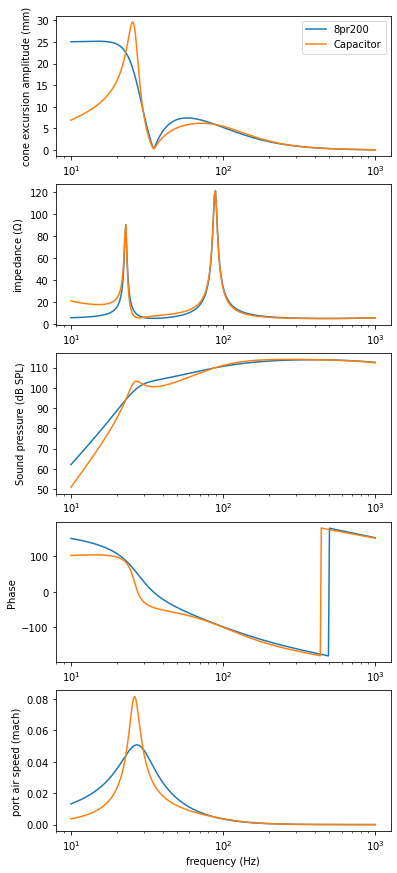

In [32]:
fig, ax = subplots(5, 1, figsize = (6, 15))

C_e = 1000
label = '8pr200'
runGraph(fp8pr200, box2)

C_e = 900e-6
label = 'Capacitor'
runGraph(fp8pr200, box2)
#runGraph(emi2512ii, box1)

#label = 'hypothetical'
#x, Z, spl, phase, v_port, p2 = xCone(**(driver2 | box1a)) 
#graphs(f, x, Z, spl, phase, v_port)

#label = 'kl3012cx'
#x, Z, spl, phase, v_port, p1 = xCone(**(kl3012cx | box2)) 
#graphs(f, x, Z, spl, phase, v_port)

#label = 'bc15cl76'
#x, Z, spl, phase, v_port, p2 = xCone(**(bc15cl76 | box3)) 
#graphs(f, x, Z, spl, phase, v_port)

# Combine the two sound pressure values

#p_ref = 20e-6 # reference pressure in Pa RMS
#spl = 20*log10(abs(p1 + p2)/p_ref)
#ax[2].semilogx(f, spl)